# Stock price prediction using LSTM neural network and Tensorflow

## Goal: Predict ' GOOGL' (Google) stock price with a horzion of 3 days.

### Steps: 
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

Author: Dmytro Sazonov

Original URL: https://medium.com/@dmytrosazonov/how-to-predict-stock-market-using-google-tensorflow-and-lstm-neural-network-81ccc41a22a8



In [44]:
# Requirements
#!pip install yahoo_fin

In [45]:
import numpy as np
import time as tm
import datetime as dt
import setuptools.dist
import tensorflow as tf

In [46]:


# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [47]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3, 4, 5]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [48]:
# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

In [49]:
init_df

,open,high,low,close,adjclose,volume,ticker
2021-11-15,148.900497,149.549500,147.574997,148.451996,148.085312,23508000,GOOGL
2021-11-16,148.149506,148.762497,147.312500,147.876007,147.510742,18904000,GOOGL
2021-11-17,148.027496,148.559494,147.240005,148.046997,147.681305,19594000,GOOGL
2021-11-18,148.241501,150.580505,147.884506,149.838501,149.468399,35608000,GOOGL
2021-11-19,149.975494,150.966507,148.899002,148.926498,148.558640,33682000,GOOGL
...,...,...,...,...,...,...,...
2024-11-14,178.279999,178.820007,174.320007,175.580002,175.580002,31007500,GOOGL
2024-11-15,173.729996,174.139999,171.220001,172.490005,172.490005,32504600,GOOGL
2024-11-18,173.419998,175.440002,172.899994,175.300003,175.300003,20206600,GOOGL
2024-11-19,173.720001,178.869995,173.559998,178.119995,178.119995,23434900,GOOGL


In [50]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [51]:
init_df

,close,date
2021-11-15,148.451996,2021-11-15
2021-11-16,147.876007,2021-11-16
2021-11-17,148.046997,2021-11-17
2021-11-18,149.838501,2021-11-18
2021-11-19,148.926498,2021-11-19
...,...,...
2024-11-14,175.580002,2024-11-14
2024-11-15,172.490005,2024-11-15
2024-11-18,175.300003,2024-11-18
2024-11-19,178.119995,2024-11-19


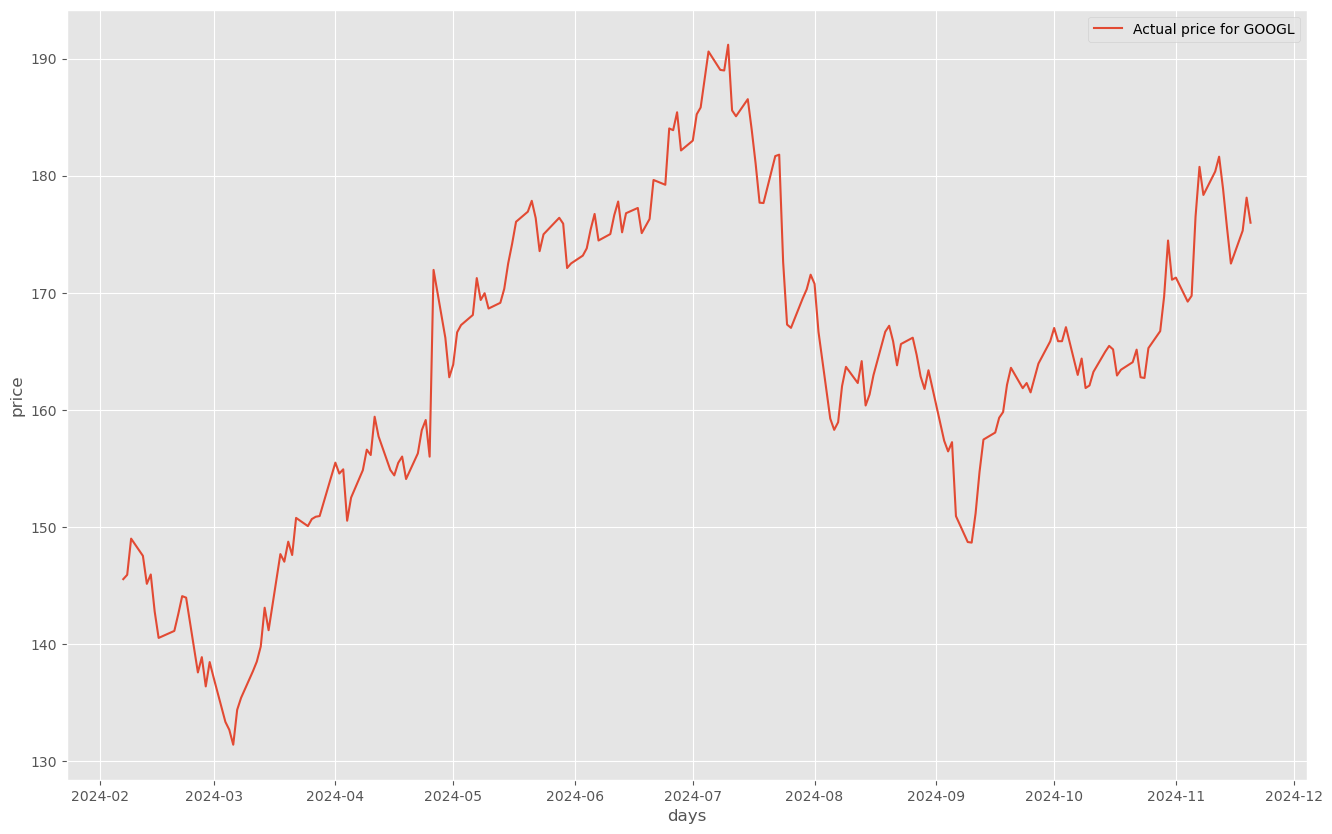

In [52]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [53]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [54]:
init_df

,close,date,scaled_close
2021-11-15,148.451996,2021-11-15,0.603452
2021-11-16,147.876007,2021-11-16,0.598107
2021-11-17,148.046997,2021-11-17,0.599694
2021-11-18,149.838501,2021-11-18,0.616320
2021-11-19,148.926498,2021-11-19,0.607856
...,...,...,...
2024-11-14,175.580002,2024-11-14,0.855220
2024-11-15,172.490005,2024-11-15,0.826543
2024-11-18,175.300003,2024-11-18,0.852622
2024-11-19,178.119995,2024-11-19,0.878794


In [55]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [72]:
PrepareData(5) # 5 days

(                 close       date  scaled_close    future
 2021-11-15  148.451996 2021-11-15      0.603452  0.583499
 2021-11-16  147.876007 2021-11-16      0.598107  0.578673
 2021-11-17  148.046997 2021-11-17      0.599694  0.581810
 2021-11-18  149.838501 2021-11-18      0.616320  0.545271
 2021-11-19  148.926498 2021-11-19      0.607856  0.576339
 ...                ...        ...           ...       ...
 2024-11-07  180.750000 2024-11-07      0.903202  0.855220
 2024-11-08  178.350006 2024-11-08      0.880928  0.826543
 2024-11-11  180.350006 2024-11-11      0.899490  0.852622
 2024-11-12  181.619995 2024-11-12      0.911276  0.878794
 2024-11-13  178.880005 2024-11-13      0.885847  0.858933
 
 [754 rows x 4 columns],
 array([[0.801021  ],
        [0.8638515 ],
        [0.90320194],
        [0.8809282 ],
        [0.8994897 ],
        [0.9112761 ],
        [0.885847  ],
        [0.8552205 ],
        [0.82654303],
        [0.8526219 ],
        [0.87879354],
        [0.85893273]], 

In [57]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [58]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80


C:\Users\PICHAU\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0303
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 16/80
94/94 ━━━━━━━━━━━

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Epoch 1/80


C:\Users\PICHAU\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0437
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024
Epoch 16/80
94/94 ━━━━━━━━━━━━

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Epoch 1/80


C:\Users\PICHAU\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0405
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0045
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoch 16/80
94/94 ━━━━━━━━━━━━

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Epoch 1/80


C:\Users\PICHAU\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0354
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoch 16/80
94/94 ━━━━━━━━━━━━

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Epoch 1/80


C:\Users\PICHAU\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0358
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0043
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043
Epoch 16/80
94/94 ━━━━━━━━━━━━

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


In [82]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 5 days ({predictions_str})'

  print(message)

GOOGL prediction for upcoming 5 days (174.51$, 174.06$, 174.63$, 175.11$, 172.08$)


In [83]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-5:], axis=1)) ### alterei de -3 para -5
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [84]:
copy_df.tail(10)

,close,date,scaled_close,predicted_close
2024-11-07,180.750000,2024-11-07,0.903202,173.029526
2024-11-08,178.350006,2024-11-08,0.880928,173.628021
2024-11-11,180.350006,2024-11-11,0.899490,174.693314
2024-11-12,181.619995,2024-11-12,0.911276,175.843185
2024-11-13,178.880005,2024-11-13,0.885847,175.116287
2024-11-14,175.580002,2024-11-14,0.855220,175.580002
2024-11-15,172.490005,2024-11-15,0.826543,172.490005
2024-11-18,175.300003,2024-11-18,0.852622,175.300003
2024-11-19,178.119995,2024-11-19,0.878794,178.119995
2024-11-20,175.979996,2024-11-20,0.858933,175.979996


In [86]:
# Add predicted results to the table
date_now = dt.date.today()
date_plus_1 = dt.date.today() + dt.timedelta(days=1)
date_plus_2_ = dt.date.today() + dt.timedelta(days=2)
date_plus_3 = dt.date.today() + dt.timedelta(days=3)
date_plus_4 = dt.date.today() + dt.timedelta(days=4)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_plus_1] = [predictions[1], f'{date_plus_1}', 0, 0]
copy_df.loc[date_plus_2_] = [predictions[2], f'{date_plus_2_}', 0, 0]
copy_df.loc[date_plus_3] = [predictions[3], f'{date_plus_3}', 0, 0]
copy_df.loc[date_plus_4] = [predictions[4], f'{date_plus_4}', 0, 0]

copy_df.tail(10)

,close,date,scaled_close,predicted_close
2024-11-14 00:00:00,175.580002,2024-11-14 00:00:00,0.855220,175.580002
2024-11-15 00:00:00,172.490005,2024-11-15 00:00:00,0.826543,172.490005
2024-11-18 00:00:00,175.300003,2024-11-18 00:00:00,0.852622,175.300003
2024-11-19 00:00:00,178.119995,2024-11-19 00:00:00,0.878794,178.119995
2024-11-20 00:00:00,175.979996,2024-11-20 00:00:00,0.858933,175.979996
2024-11-21,174.510000,2024-11-21,0.000000,0.000000
2024-11-22,174.060000,2024-11-22,0.000000,0.000000
2024-11-23,174.630000,2024-11-23,0.000000,0.000000
2024-11-24,175.110000,2024-11-24,0.000000,0.000000
2024-11-25,172.080000,2024-11-25,0.000000,0.000000


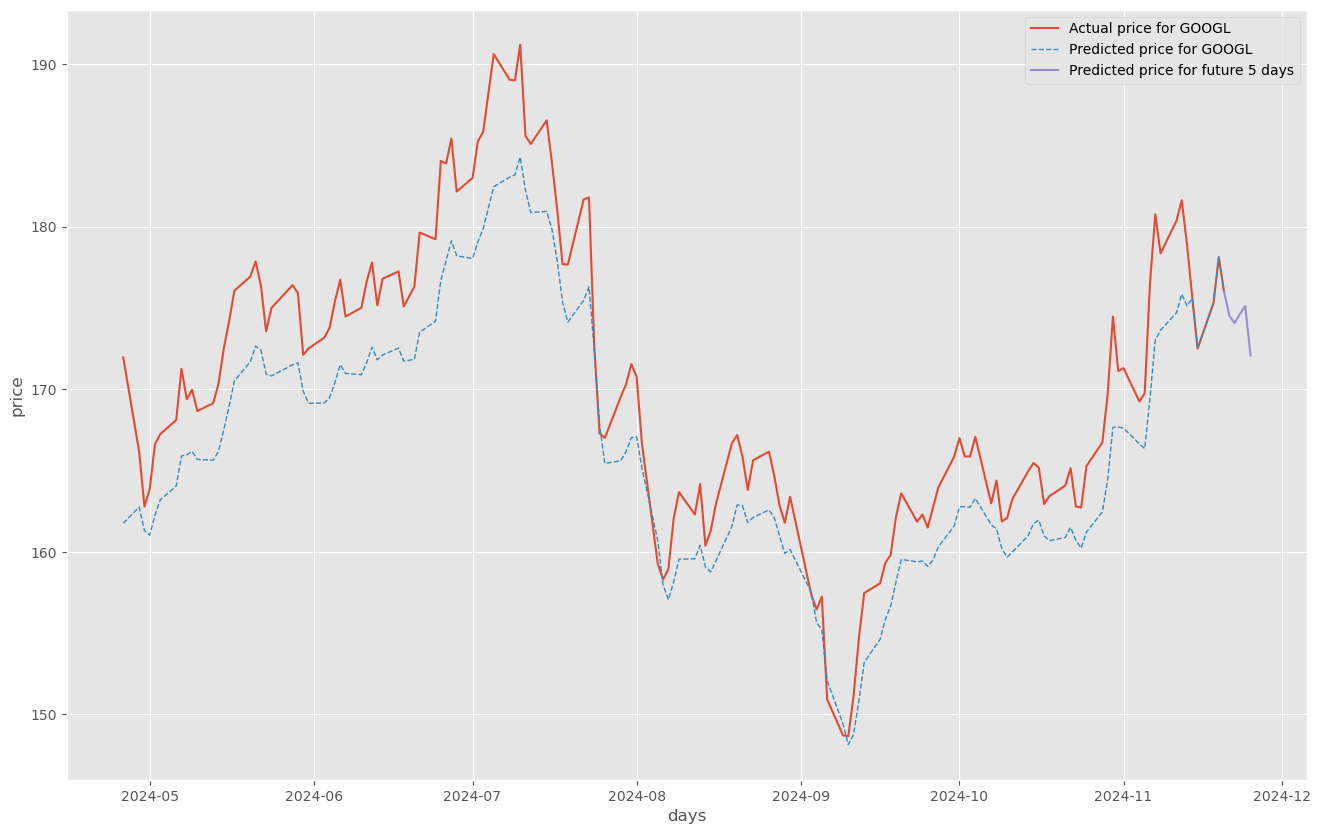

In [87]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(145))
plt.plot(copy_df['predicted_close'][-150:].head(145), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(6))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 5 days'])
plt.show()